In [1]:
%load_ext autoreload
%autoreload 2

# IMPORT

In [2]:
import pandas as pd
from tqdm import tqdm

from src.process_tracking import process_data
from src.individual_pitch_control import extract_all_for_position_across_match, plot_half_pitch_individual_pitch_control, process_all_matches_parallel
from src.clustering import prepare_clustering_features_single_match, prepare_clustering_features_all_matches, predict_clusters, plot_cluster_summary_pitch_control, plot_players_cluster_distribution
from src.soccermap_models import predict_maps, compute_metrics
from src.analysis_plots import plot_player_percentiles
from src.utils import concat_all_meta_from_gcs

/opt/conda/envs/analytics_cup/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [8]:
# Project_id GCP dans un .env

Some details regarding the run of this project:

- To complete this project, I had to save certain files and models as I go (to reduce RAM usage, avoid having to rerun everything each time, etc.). 

- My save and load functions are based on GCP, but they can easily be adapted to another cloud platform.

- However you can run everything in this notebook without saving files : in each section, I have included both a cell to run the code on a single file without saving the output, and a cell to run it on multiple files and save the output.

- All the steps run fast, except the train of the 2 Deep Learning models, so to make running easier, I have saved the two models in the repo in a lightweight format. 

# PROCESS TRACKING DATA

Before going into the core of the topic, we must prepare tracking data:
- Rescale coordinates to a 105x68 pitch
- Calculate velocities
- Retrieve meta data and merge with event data
- Normalize directions (always attacking left to right)

In [3]:
# RUN ON A SINGLE MATCH

df_processed = process_data(match_id=1886347, save_to_gcs=False)

[match 1886347] rows: 724617, players: 693106, ball: 31511


Merging match 1886347: 100%|██████████| 999/999 [00:03<00:00, 316.11it/s]


In [ ]:
# RUN ON ALL MATCHES AND SAVE OUTPUTS

match_ids = [1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725, 2015213, 2017461]

for match_id in tqdm(match_ids, total=len(match_ids)):
    process_data(match_id=match_id, save_to_gcs=True)

# CALCULATE INDIVIDUAL PITCH CONTROL

As explained in the abstract, the objective of the project is to analyse and evaluate the space controled by a given player position in a given game situation.

In this notebook, we have pre-selected :
- player position : **center forwards** 
- game situation : **team out of possession is low block**

But the code works for any player position and any game situation, so feel free to change the values below !

In [4]:
player_position = "center_forward"
game_situation = ('team_out_of_possession_phase_type','low_block')

This first step enables to calculate what we call the "Individual Pitch Control", which is the Spearman's physics-based Pitch Control model definition, applied only to a single player : instead of summing the probabilities of each player of the teams, we only take into account the probability of a single player of a team and the sum of the probabilities of all the players of the opponent team. We do that to focus only on the space created by this player.
The output is a (32x50) map of the half-pitch.

We also calculate features that describe the game situation and that we will include in our clustering model (next step) : opponent defensive lines (calculated with an Agglomerative Clustering method) and contextual information about the player we focus on (distance from the ball, from nearest opponent, etc.)

In [5]:
# RUN ON A SINGLE MATCH

results = extract_all_for_position_across_match(
        match_id=1886347,
        player_position=player_position,
        game_situation=game_situation,
        df=df_processed,
        sample_size=10,
        resolution=1
    )


 Processing complete: 10 frames analyzed in total.


In [6]:
results[0]

{'pitch_control_map': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'defensive_lines': [24.099519230769246, 65.8016826923077, 81.2],
 'frame': 58560,
 'player_id': 966120,
 'player_position': (nan, nan),
 'ball_position': (65.48365384615386, 27.119999999999997),
 'in_possession': False,
 'distance_to_ball': nan,
 'distance_to_nearest_teammate': nan,
 'distance_to_nearest_opponent': nan,
 'player_position_role': 'center_forward'}

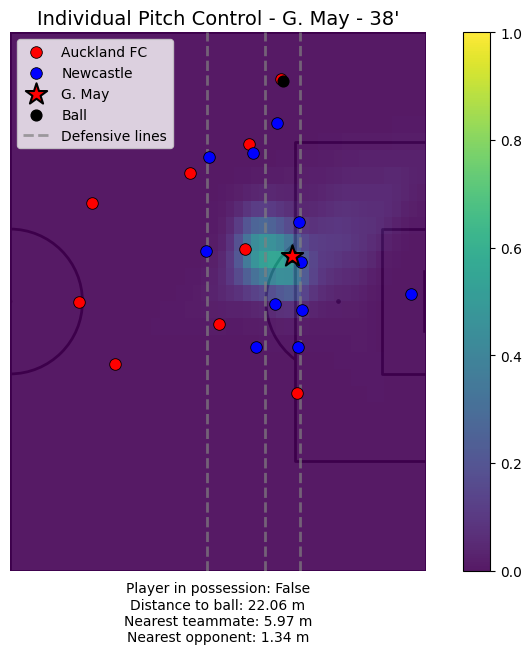

In [12]:
plot_half_pitch_individual_pitch_control(
    df=df_processed,
    frame_results=results[0]
)

In [8]:
# RUN ON ALL MATCHES AND SAVE OUTPUTS

process_all_matches_parallel(
    player_position=player_position,
    game_situation=game_situation,
    pitch_control_resolution= 1,
    max_workers= 10,
)

10 matches detected
 File already exists for match 2011166
 File already exists for match 1996435
 File already exists for match 2015213
 File already exists for match 2013725 File already exists for match 1899585
 File already exists for match 1953632

 File already exists for match 1886347
 File already exists for match 2006229
 File already exists for match 1925299
 File already exists for match 2017461


# IDENTIFY SPACE CLUSTERS

This second step enables to identify the main types of space controlled by a player (with always the focus of player position x game situation).

Thus we can determine player profiles about the spaces they create (and in the next step we will be able to evaluate how efficient and dangerous the spaces for each cluster).

In [7]:
# RUN ON A SINGLE MATCH

X, meta = prepare_clustering_features_single_match(
    results= results,
    processed_df= df_processed,
    match_id= 1886347,
    game_situation= game_situation
)

meta_clusters = predict_clusters(
    player_position=player_position, 
    game_situation=game_situation, 
    X=X, 
    meta=meta, 
    model_local=True
)

In [8]:
meta_clusters

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,game_situation,cluster,cluster_gathered
0,1886347,26660,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,44,low_block,0,0
1,1886347,20491,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,34,low_block,3,1
2,1886347,29325,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,2,low_block,0,0
3,1886347,1122,966120,center_forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,3,1
4,1886347,26635,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,44,low_block,0,0
5,1886347,16272,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,27,low_block,8,3
6,1886347,29199,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,2,low_block,0,0


In [26]:
# RUN ON ALL MATCHES AND SAVE OUTPUTS

X, meta, frames_inputs = prepare_clustering_features_all_matches(
    player_position=player_position,
    game_situation=game_situation
)

meta_clusters = predict_clusters(
    player_position=player_position, 
    game_situation=game_situation, 
    X=X, 
    meta=meta, 
    model_local=True
)

100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


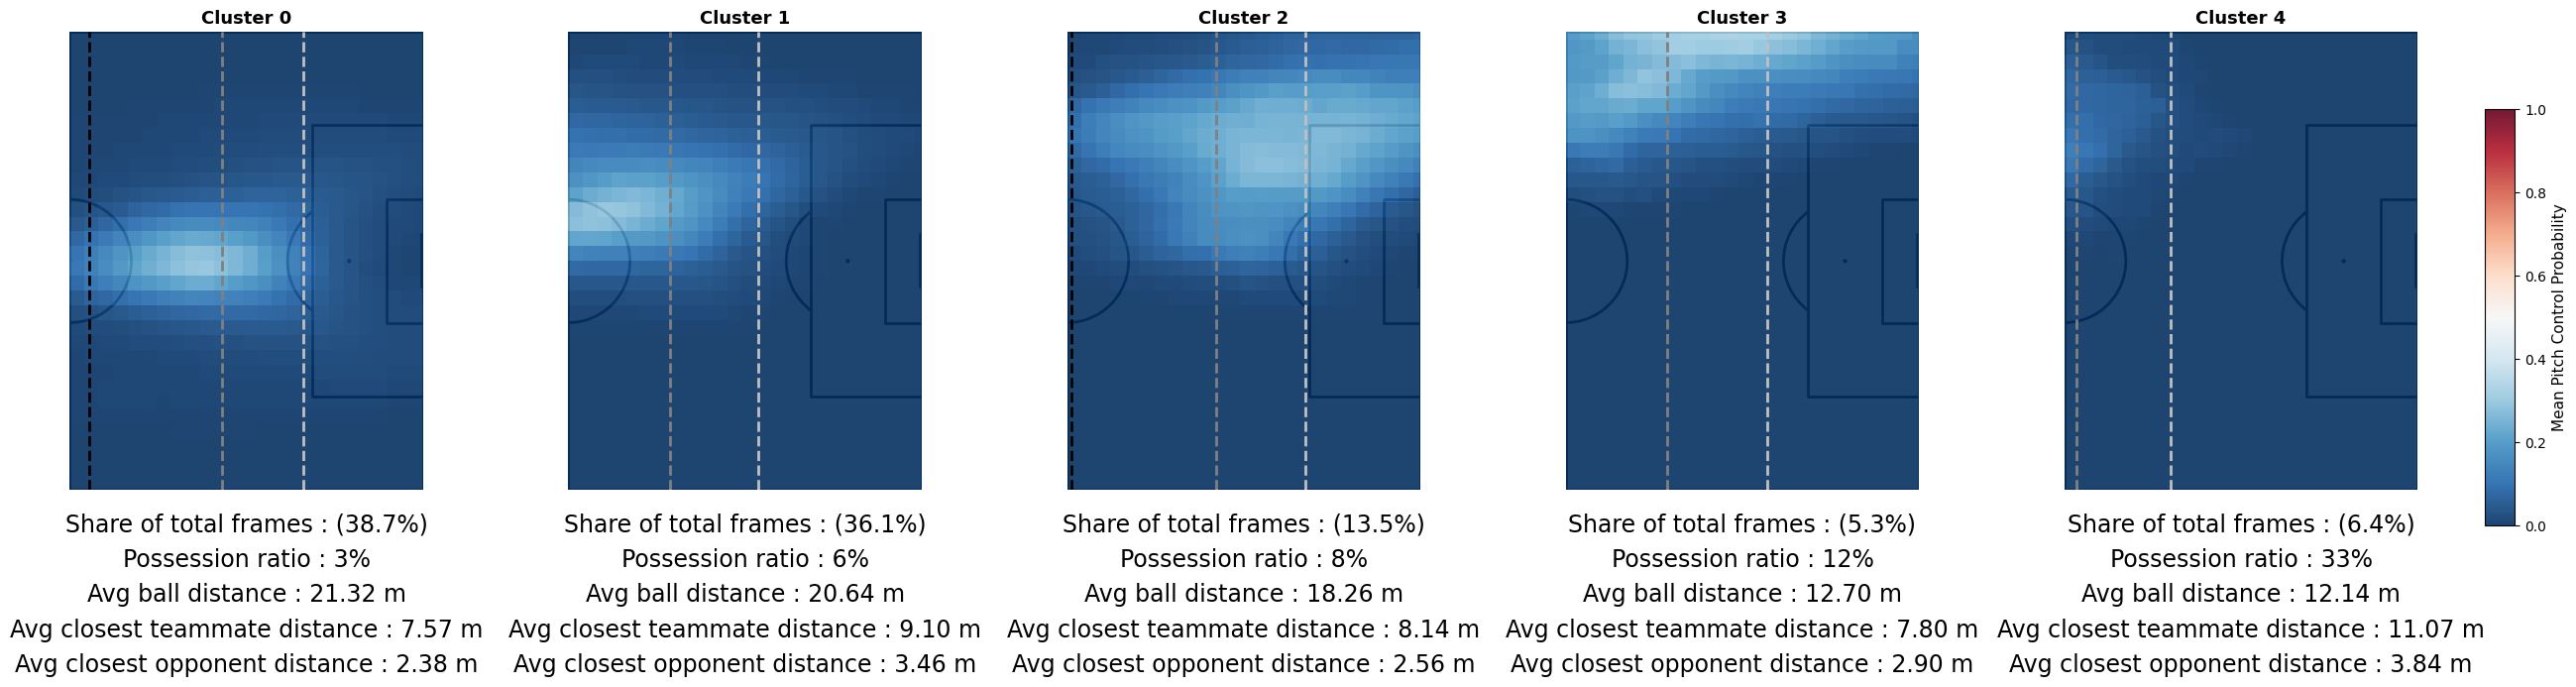

In [29]:
plot_cluster_summary_pitch_control(
    results=frames_inputs,
    meta=meta_clusters
)

The space categories for center forwards against low block defense can be interpreted as below :
- cluster 0 : In the center, between defensive lines / Rarely with the ball (not participating to build-up) / Most frequent pitch control
- cluster 1 : In the center/slightly on the side / Around the 2nd defensive line / Rarely with the ball (not participating to build-up)
- cluster 2 : Slightly on the side / Covering in front of and behind last defensive line, ready for runs in behind / Most offensive pitch control
- cluster 3 : On the side / Going back or lateral to create spaces for build-up (often with the ball) / Spaces closer to the ball
- cluster 4 : On the side / Going back or lateral to create spaces for build-up (often with the ball) / Spaces closer to the ball

In this repo, you will only find this pre-trained clustering model (for center forward x low block defense).
You can find the function to train your clustering model on the player position and game situation of your choice (but it requires iterations and interpretations).

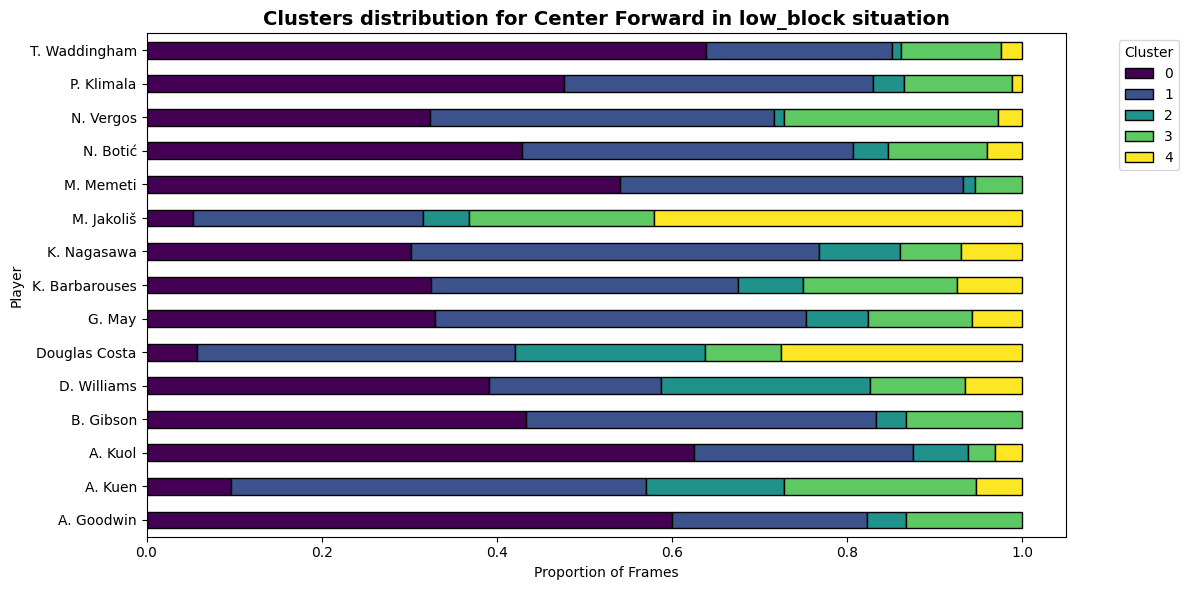

In [30]:
plot_players_cluster_distribution(
    meta=meta_clusters
)

# EVALUATE SPACES WITH SOCCERMAP MODELS

The last step consists in evaluating the relevancy and the danger of the space created by the player.
To do so, we leverage the Soccermap approach to train 2 CNN models :
- xPass (enables to evaluate the "relevancy" of the space : is the space realistic and reachable ?)
- XThreat (enables to evaluate the "danger" of the space : how likely is the team to score in the 10 next seconds if the ball goes to the space ?)

We introduce the metric **"iscT" : Individual Space Controlled Threat** :
- It is the weighted average of the xT of the spaces controlled by the player, weighted by the Individual Pitch Control and the xPass probabilities
- Intuition : the more likely the player is to control the space — and for a pass into that space to be successful — the more weight we assign to the xT


To make this metric usable — i.e. to be able to compare different situations and different players — we prefer to analyze how much these controlled spaces would increase the probability of scoring compared to the on-ball xT : **iscT-Δ : Individual Space Controlled Threat Increase**

In [9]:
iscT, iscT_delta = predict_maps(
    match_id=1886347,
    df=df_processed,
    frame_results=results,
    model_local=True
)

/home/jupyter/Arthur/analytics_cup_research/src/soccermap_models.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # 6 SPARSE CHANNELS: (att: loc,vx,vy) + (def: loc,vx,vy)


IndexError: single positional indexer is out-of-bounds

In [10]:
meta_out = compute_metrics(
    meta=meta_clusters,
    df=df_processed,
    frame_results=results,
    model_local=True,
    batch_size=32,
    save_to_gcs=False
)

Matches: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


In [11]:
meta_out

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,game_situation,cluster,cluster_gathered,iscT,iscT_delta
0,1886347,26660,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,44,low_block,0,0,0.031448,-0.063152
1,1886347,20491,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,34,low_block,3,1,0.043467,0.035789
2,1886347,29325,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,2,low_block,0,0,0.036586,-0.031055
3,1886347,1122,966120,center_forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,3,1,0.054419,0.048736
4,1886347,26635,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,44,low_block,0,0,0.045489,-0.068911
5,1886347,16272,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,27,low_block,8,3,0.015488,-0.069177
6,1886347,29199,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,2,low_block,0,0,0.049843,-0.033146


In [12]:
meta_all = concat_all_meta_from_gcs()

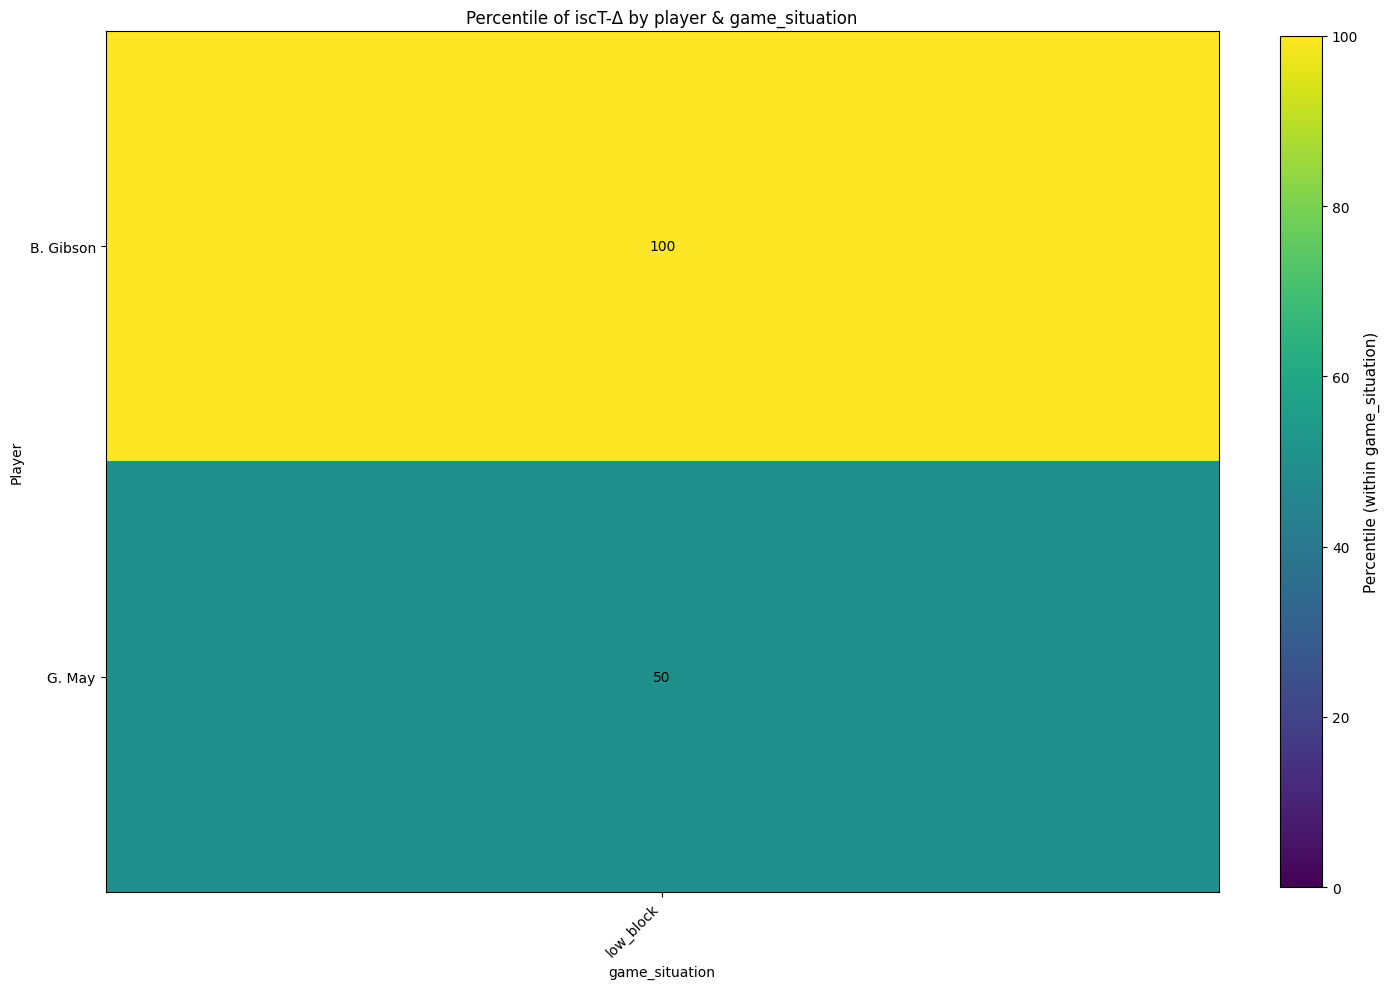

In [14]:
pivot_percentiles = plot_player_percentiles(
    meta_out=meta_out,
    dimension_col="game_situation"
)

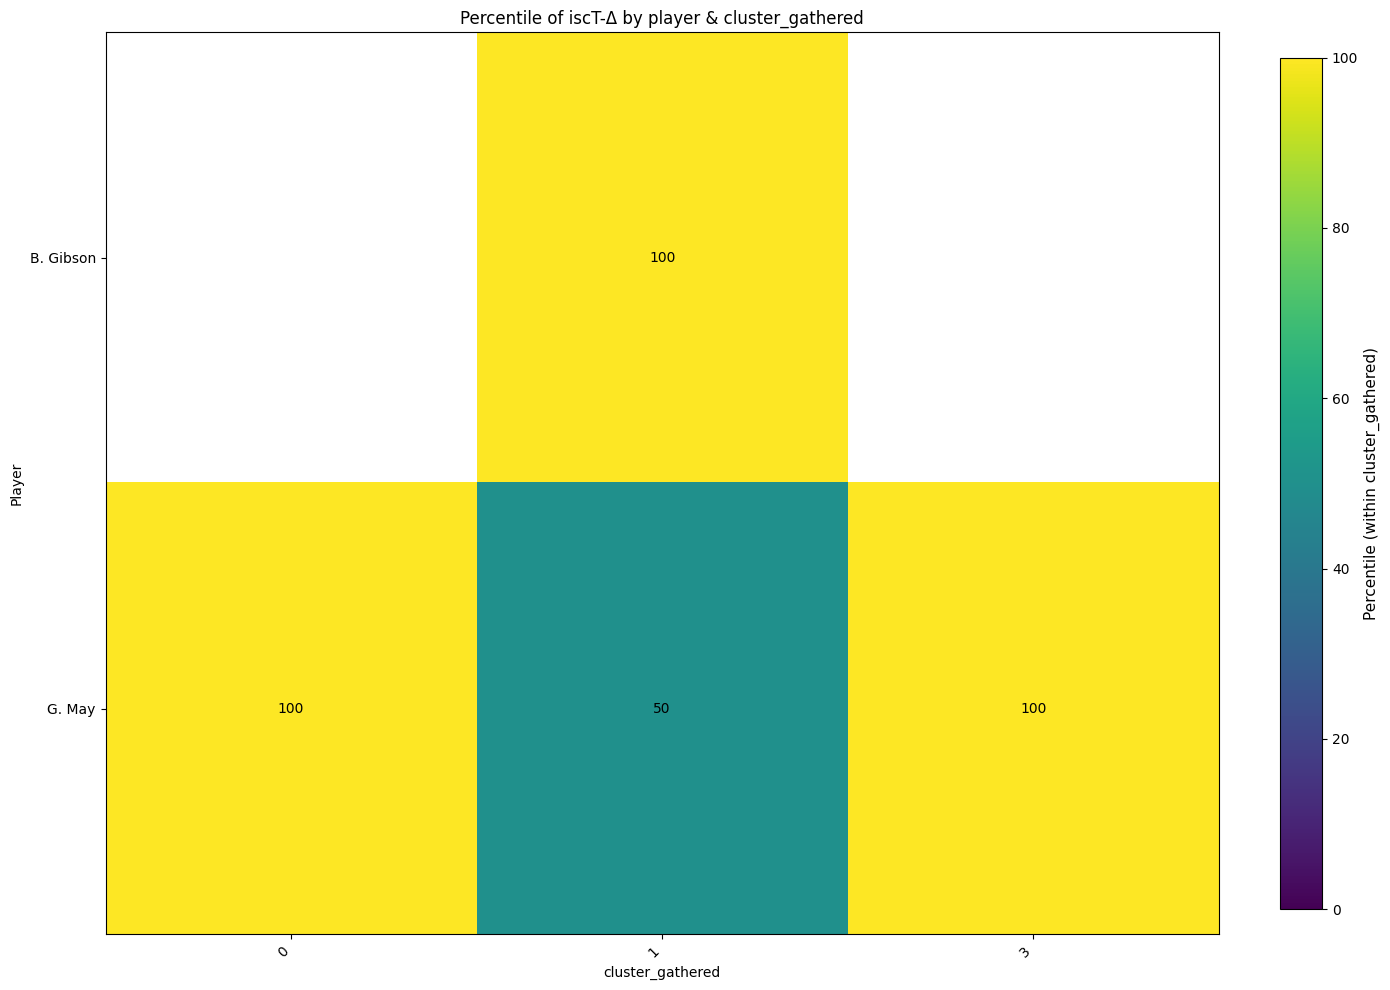

In [17]:
pivot_percentiles = plot_player_percentiles(
    meta_out=meta_out,
    dimension_col="cluster_gathered",
    game_situation_filter="low_block"
)